# Experiments on vanilla NADE(Neural Autoregressive Density Estimation)
* [paper](http://proceedings.mlr.press/v15/larochelle11a/larochelle11a.pdf)
* GPU is enabled: 
> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**


<table align="left"><td>
<a target="_blank" href="https://colab.research.google.com/drive/1tzlvd-fzBgRP0-rhSePW9Fyq6B_RSnN3?usp=sharing">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>  
</td><td>
<a target="_blank" href=""><img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a></td></table>

# 01. Set-up

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
cd /content/gdrive/MyDrive/colab-github/STAT37792

/content/gdrive/MyDrive/colab-github/STAT37792


### Dataset: Binarized MNIST

In [ ]:
"""Extra generative modeling benchmark datasets not provided by PyTorch."""

import os
import urllib

import PIL
import numpy as np
import torch
from torch import distributions
from torch.nn import functional as F
from torch.utils import data
from torchvision import datasets
from torchvision import transforms
from torchvision.datasets import utils
from torchvision.datasets import vision

def _dynamically_binarize(x):
    return distributions.Bernoulli(probs=x).sample()


def _resize_to_32(x):
    return F.pad(x, (2, 2, 2, 2))

    
def get_mnist_loaders(batch_size, dynamically_binarize=False, resize_to_32=False):
    """Create train and test loaders for the MNIST dataset.
    Args:
        batch_size: The batch size to use.
        dynamically_binarize: Whether to dynamically  binarize images values to {0, 1}.
        resize_to_32: Whether to resize the images to 32x32.
    Returns:
        Tuple of (train_loader, test_loader).
    """
    transform = [transforms.ToTensor()]
    if dynamically_binarize:
        transform.append(_dynamically_binarize)
    if resize_to_32:
        transform.append(_resize_to_32)
    transform = transforms.Compose(transform)
    train_loader = data.DataLoader(
        datasets.MNIST("/tmp/data", train=True, download=True, transform=transform),
        batch_size=batch_size,
        shuffle=True,
        num_workers=os.cpu_count(),
    )
    test_loader = data.DataLoader(
        datasets.MNIST("/tmp/data", train=False, download=True, transform=transform),
        batch_size=batch_size,
        num_workers=os.cpu_count(),
    )
    return train_loader, test_loader

In [ ]:
train_loader, test_loader = get_mnist_loaders(batch_size = 512, dynamically_binarize=True)

In [ ]:
for image, label  in train_loader:
  sample = image[0:10]
  sample_label = label[0:10]

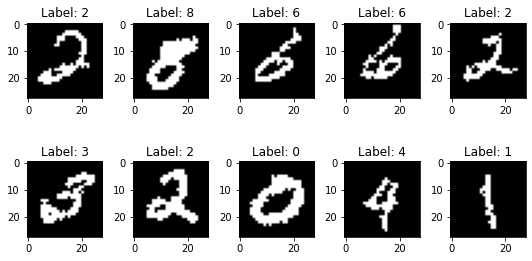

In [ ]:
import matplotlib.pyplot as plt

num = 10
num_row = 2
num_col = 5
# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(sample[i].reshape(28,28), cmap='gray')
    ax.set_title('Label: {}'.format(sample_label[i]))
plt.tight_layout()
plt.show()

# 02. NADE architecture

In [ ]:
import torch

In [ ]:
import numpy as np
np.random.seed(1234)
dim_list = np.arange(784)
np.random.shuffle(dim_list)

In [ ]:
"""Base classes for models."""

import abc

import torch
from torch import distributions
from torch import nn


def _default_sample_fn(logits):
    return distributions.Bernoulli(logits=logits).sample()


class GenerativeModel(abc.ABC, nn.Module):
    """Base class inherited by all generative models in pytorch-generative.

    Provides:
        * An abstract `sample()` method which is implemented by subclasses that support
          generating samples.
        * Variables `self._c, self._h, self._w` which store the shape of the (first)
          image Tensor the model was trained with. Note that `forward()` must have been
          called at least once and the input must be an image for these variables to be
          available.
        * A `device` property which returns the device of the model's parameters.
    """

    def __call__(self, *args, **kwargs):
        if getattr(self, "_c", None) is None and len(args[0].shape) == 4:
            _, self._c, self._h, self._w = args[0].shape
        return super().__call__(*args, **kwargs)

    @property
    def device(self):
        return next(self.parameters()).device

    @abc.abstractmethod
    def sample(self, n_samples):
        ...


class AutoregressiveModel(GenerativeModel):
    """The base class for Autoregressive generative models. """

    def __init__(self, sample_fn=None):
        """Initializes a new AutoregressiveModel instance.

        Args:
            sample_fn: A fn(logits)->sample which takes sufficient statistics of a
                distribution as input and returns a sample from that distribution.
                Defaults to the Bernoulli distribution.
        """
        super().__init__()
        self._sample_fn = sample_fn or _default_sample_fn

    def _get_conditioned_on(self, n_samples, conditioned_on):
        assert (
            n_samples is not None or conditioned_on is not None
        ), 'Must provided one, and only one, of "n_samples" or "conditioned_on"'
        if conditioned_on is None:
            shape = (n_samples, self._c, self._h, self._w)
            conditioned_on = (torch.ones(shape) * -1).to(self.device)
        else:
            conditioned_on = conditioned_on.clone()
        return conditioned_on

    # TODO(eugenhotaj): This function does not handle subpixel sampling correctly.
    def sample(self, n_samples=None, conditioned_on=None):
        """Generates new samples from the model.

        Args:
            n_samples: The number of samples to generate. Should only be provided when
                `conditioned_on is None`.
            conditioned_on: A batch of partial samples to condition the generation on.
                Only dimensions with values < 0 are sampled while dimensions with
                values >= 0 are left unchanged. If 'None', an unconditional sample is
                generated.
        """
        with torch.no_grad():
            conditioned_on = self._get_conditioned_on(n_samples, conditioned_on)
            n, c, h, w = conditioned_on.shape
            for row in range(h):
                for col in range(w):
                    out = self.forward(conditioned_on)[:, :, row, col]
                    out = self._sample_fn(out).view(n, c)
                    conditioned_on[:, :, row, col] = torch.where(
                        conditioned_on[:, :, row, col] < 0,
                        out,
                        conditioned_on[:, :, row, col],
                    )
            return conditioned_on

In [ ]:
import torch
from torch import distributions
from torch import nn

class NADE(AutoregressiveModel):
    """The Neural Autoregressive Distribution Estimator (NADE) model."""

    def __init__(self, input_dim, hidden_dim):
        """Initializes a new NADE instance.

        Args:
            input_dim: The dimension of the input.
            hidden_dim: The dimmension of the hidden layer. NADE only supports one
                hidden layer.
        """
        super().__init__()
        self._input_dim = input_dim

        # fmt: off
        self._W = nn.Parameter(torch.zeros(hidden_dim, self._input_dim))
        self._c = nn.Parameter(torch.zeros(hidden_dim,))
        self._V = nn.Parameter(torch.zeros(self._input_dim, hidden_dim))
        self._b = nn.Parameter(torch.zeros(self._input_dim,))
        # fmt: on
        nn.init.kaiming_normal_(self._W)
        nn.init.kaiming_normal_(self._V)
        

    def _forward(self, x):
        """Computes the forward pass and samples a new output.

        Returns:
            (p_hat, x_hat) where p_hat is the probability distribution over dimensions
            and x_hat is sampled from p_hat.
        """
        # fix the order
        # x = x[order]
         
        # If the input is an image, flatten it during the forward pass.
        original_shape = x.shape
        if len(x.shape) > 2:
            x = x.view(original_shape[0], -1)

        p_hat, x_hat = [], []
        batch_size = 1 if x is None else x.shape[0]
        # Only the bias is used to compute the first hidden unit so we must replicate it
        # to account for the batch size.
        a = self._c.expand(batch_size, -1)
        for i in range(self._input_dim):
            h = torch.sigmoid(a)
            p_i = torch.sigmoid(h @ self._V[i : i + 1, :].t() + self._b[i : i + 1])
            p_hat.append(p_i)

            # Sample 'x' at dimension 'i' if it is not given.
            x_i = x[:, i : i + 1]
            x_i = torch.where(x_i < 0, distributions.Bernoulli(probs=p_i).sample(), x_i)
            x_hat.append(x_i)

            # We do not need to add self._in_b[i:i+1] when computing the other hidden
            # units since it was already added when computing the first hidden unit.
            a = a + x_i @ self._W[:, i : i + 1].t()
        if x_hat:
            return (
                torch.cat(p_hat, dim=1).view(original_shape),
                torch.cat(x_hat, dim=1).view(original_shape),
            )
        return []

    def forward(self, x):
        """Computes the forward pass.

        Args:
            x: Either a tensor of vectors with shape (n, input_dim) or images with shape
                (n, 1, h, w) where h * w = input_dim.
        Returns:
            The result of the forward pass.
        """
        return self._forward(x)[0]

    def sample(self, n_samples=None, conditioned_on=None):
        """See the base class."""
        with torch.no_grad():
            conditioned_on = self._get_conditioned_on(n_samples, conditioned_on)
            return self._forward(conditioned_on)[1]

Based on the code given written by Hugo Larochelle, updates have been made to run using torch.

# 03. Training

In [ ]:
nade = NADE(input_dim = 784, hidden_dim = 500)

In [ ]:
from torch import optim
from torch.nn import functional as F

n_epochs=50
batch_size=512
debug_loader=None

In [ ]:
def loss_fn(x, _, preds):
    batch_size = x.shape[0]
    x, preds = x.view((batch_size, -1)), preds.view((batch_size, -1))
    loss = F.binary_cross_entropy_with_logits(preds, x, reduction="none")
    return loss.sum(dim=1).mean()

optimizer = optim.Adam(nade.parameters())

In [ ]:
"""Utilities to train PyTorch models with less boilerplate."""

import collections
import glob
import os
import re
import tempfile
import time

import torch
from torch import nn
from torch.nn import parallel
from torch.nn import utils
from torch.utils import tensorboard


class Trainer:
    """An object which encapsulates the training and evaluation loop.

    Note that the trainer is stateful. This means that calling
    `trainer.continuous_train_and_eval()` a second time will cause training
    to pick back up from where it left off.
    """

    def __init__(
        self,
        model,
        loss_fn,
        optimizer,
        train_loader,
        eval_loader,
        lr_scheduler=None,
        clip_grad_norm=None,
        skip_grad_norm=None,
        sample_epochs=None,
        sample_fn=None,
        log_dir=None,
        save_checkpoint_epochs=1,
        n_gpus=0,
        device_id=None,
    ):
        """Initializes a new Trainer instance.

        Args:
            model: Model to train and evaluate.
            loss_fn: A `fn(inputs, targets, predictions)->output`. The output can either
                be a single loss Tensor or a metrics dictionary containing multiple
                Tensors. The dictionary must contain a `loss` key which will be used as
                the primary loss for backprop.
            optimizer: Optimizer to use when training.
            train_loader: DataLoader for the training set.
            eval_loader: DataLoader for the evaluation set.
            lr_scheduler: An torch.optim.lr_scheduler whose step() method is called
                after every batch.
            clip_grad_norm: L2 norm to scale gradients to if their norm is greater.
            skip_grad_norm: Maximum L2 norm above which gradients are discarded.
            sample_epochs: Number of epochs to wait between generating new image samples
                and logging them to TensorBoard. If not `None`, `sample_fn` must be
                provided.
            sample_fn: A `fn(model)->Tensor` which returns an NCHW Tensor of images to
                log to TensorBoard.
            log_dir: The directory where to log checkpoints and TensorBoard metrics. If
                `None` a temporary directory is created (note that this directory is not
                cleaned up automatically).
            save_checkpoint_epochs: Number of epochs to wait between checkpoints. Note
                that this does not affect TensorBoard logging frequency.
            n_gpus: The number of GPUs to use for training and evaluation. If 0, the
                CPUs are used instead.
            device_id: When running on multiple GPUs, the id of the GPU device this
                Trainer instance is running on.
        """
        self.loss_fn = loss_fn
        self.train_loader = train_loader
        self.eval_loader = eval_loader
        self.clip_grad_norm = clip_grad_norm
        self.skip_grad_norm = skip_grad_norm
        self.log_dir = log_dir or tempfile.mkdtemp()
        self.save_checkpoint_epochs = save_checkpoint_epochs

        self.sample_epochs = sample_epochs
        self.sample_fn = sample_fn
        if self.sample_epochs:
            msg = "sample_fn cannot be None if sample_epochs is not None"
            assert self.sample_fn, msg

        self.device = "cuda" if n_gpus > 0 else "cpu"
        self.device_id = 0 if device_id is None and n_gpus == 1 else device_id
        model = model.to(self.device)
        if n_gpus > 1:
            assert device_id is not None, "'device_id' must be provided if n_gpus > 1."
            model = parallel.DistributedDataParallel(
                model, device_ids=[self.device_id], output_device=self.device_id
            )

        # Trainer state saved during checkpointing.
        self.model = model
        self.optimizer = optimizer
        self.lr_scheduler = lr_scheduler
        self._step = 0
        self._epoch = 0
        self._examples_processed = 0
        self._time_taken = 0

        self._summary_writer = tensorboard.SummaryWriter(self.log_dir, max_queue=100)

    def _path(self, file_name):
        return os.path.join(self.log_dir, file_name)

    def _save_checkpoint(self):
        if self.device_id != 0 or self._epoch % self.save_checkpoint_epochs != 0:
            return
        checkpoint = {
            "model": self.model.state_dict(),
            "optimizer": self.optimizer.state_dict(),
            "step": self._step,
            "epoch": self._epoch,
            "examples_processed": self._examples_processed,
            "time_taken": self._time_taken,
        }
        if self.lr_scheduler is not None:
            checkpoint["lr_scheduler"] = self.lr_scheduler.state_dict()
        # TODO(eugenhotaj): Add an option to keep only the last n checkpoints.
        torch.save(checkpoint, self._path(f"trainer_state_{self._epoch}.ckpt"))

    def _find_latest_epoch(self):
        files = glob.glob(self._path("trainer_state_[0-9]*.ckpt"))
        epochs = sorted([int(re.findall(r"\d+", f)[0]) for f in files])
        if not epochs:
            raise FileNotFoundError(f"No checkpoints found in {self.log_dir}.")
        print(f"Found {len(epochs)} saved checkpoints.")
        return epochs[-1]

    def restore_checkpoint(self, epoch=None):
        """Restores the Trainer's state using self.log_dir.

        Args:
            epoch: Epoch from which to restore the Trainer's state. If None, uses the
                latest available epoch.
        """
        epoch = epoch or self._find_latest_epoch()
        checkpoint = f"trainer_state_{epoch}.ckpt"
        print(f"Restoring trainer state from checkpoint {checkpoint}.")
        checkpoint = torch.load(self._path(checkpoint))

        self.model.load_state_dict(checkpoint["model"])
        self.optimizer.load_state_dict(checkpoint["optimizer"])
        self._step = checkpoint["step"]
        self._epoch = checkpoint["epoch"]
        self._examples_processed = checkpoint["examples_processed"]
        self._time_taken = checkpoint["time_taken"]
        if self.lr_scheduler is not None:
            self.lr_scheduler.load_state_dict(checkpoint["lr_scheduler"])

        # NOTE(eugenhotaj): We need to replace the SummaryWriter and ensure any
        # logs written after the last saved checkpoint are purged.
        self._summary_writer.close()
        self._summary_writer = tensorboard.SummaryWriter(
            self.log_dir, max_queue=100, purge_step=self._step
        )

    def _get_metrics_dict(self, loss_or_metrics):
        metrics = loss_or_metrics
        if not isinstance(metrics, dict):
            metrics = {"loss": metrics}
        assert "loss" in metrics, 'Metrics dictionary does not contain "loss" key.'
        return metrics

    # TODO(eugenhotaj): Consider removing the 'training' argument and just using
    # self.model.parameters().training.
    def _log_metrics(self, metrics, training):
        for key, metric in metrics.items():
            self._summary_writer.add_scalars(
                f"metrics/{key}", {"train" if training else "eval": metric}, self._step
            )

    def train_one_batch(self, x, y):
        """Trains the model on a single batch of examples.

        Subclasses can override this method to define custom training loops.
        """
        preds = self.model(x)
        return self.loss_fn(x, y, preds)

    def _train_one_batch(self, x, y):
        self.model.train()
        x = x.to(self.device)
        if y is not None:
            y = y.to(self.device)
        self.optimizer.zero_grad()
        metrics = self._get_metrics_dict(self.train_one_batch(x, y))
        metrics["loss"].backward()

        # NOTE: We use 1e50 to ensure norm is logged when not modifying gradients.
        max_norm = self.clip_grad_norm or self.skip_grad_norm or 1e50
        norm = utils.clip_grad_norm_(self.model.parameters(), max_norm)
        # TODO(eugenhotaj): Log grad_norm in a separate section from metrics.
        metrics["grad_norm"] = norm

        if not self.skip_grad_norm or norm.item() <= self.skip_grad_norm:
            self.optimizer.step()
            if self.lr_scheduler is not None:
                self.lr_scheduler.step()

        return {k: v.item() for k, v in metrics.items()}

    def eval_one_batch(self, x, y):
        """Evaluates the model on a single batch of examples.

        Subclasses can override this method to define custom evaluation loops.
        """
        preds = self.model(x)
        return self.loss_fn(x, y, preds)

    def _eval_one_batch(self, x, y):
        with torch.no_grad():
            self.model.eval()
            x = x.to(self.device)
            if y is not None:
                y = y.to(self.device)
            metrics = self._get_metrics_dict(self.eval_one_batch(x, y))
            return {k: v.item() for k, v in metrics.items()}

    def interleaved_train_and_eval(self, max_epochs, restore=True):
        """Trains and evaluates (after each epoch).

        Args:
            max_epochs: Maximum number of epochs to train for.
            restore: Wether to continue training from an existing checkpoint in
                self.log_dir.
        """
        if restore:
            try:
                self.restore_checkpoint()
            except FileNotFoundError:
                pass  # No checkpoint found in self.log_dir; train from scratch.

        for _ in range(max_epochs - self._epoch):
            start_time = time.time()

            # Train.
            for i, batch in enumerate(self.train_loader):
                batch = batch if isinstance(batch, (tuple, list)) else (batch, None)
                x, y = batch
                self._examples_processed += x.shape[0]
                lrs = {
                    f"group_{i}": param["lr"]
                    for i, param in enumerate(self.optimizer.param_groups)
                }
                self._summary_writer.add_scalars("metrics/lr", lrs, self._step)
                metrics = self._train_one_batch(x, y)
                self._log_metrics(metrics, training=True)

                self._time_taken += time.time() - start_time
                start_time = time.time()
                self._summary_writer.add_scalar(
                    "speed/examples_per_sec",
                    self._examples_processed / self._time_taken,
                    self._step,
                )
                self._summary_writer.add_scalar(
                    "speed/millis_per_example",
                    self._time_taken / self._examples_processed * 1000,
                    self._step,
                )
                self._summary_writer.add_scalar("speed/epoch", self._epoch, self._step)
                self._summary_writer.add_scalar("speed/step", self._step, self._step)
                self._step += 1

            # Evaluate
            n_examples, sum_metrics = 0, collections.defaultdict(float)
            for batch in self.eval_loader:
                batch = batch if isinstance(batch, (tuple, list)) else (batch, None)
                x, y = batch
                n_batch_examples = x.shape[0]
                n_examples += n_batch_examples
                for key, metric in self._eval_one_batch(x, y).items():
                    sum_metrics[key] += metric * n_batch_examples
            metrics = {key: metric / n_examples for key, metric in sum_metrics.items()}
            self._log_metrics(metrics, training=False)

            self._epoch += 1
            self._save_checkpoint()
            if self.sample_epochs and self._epoch % self.sample_epochs == 0:
                self.model.eval()
                with torch.no_grad():
                    tensor = self.sample_fn(self.model)
                self._summary_writer.add_images("sample", tensor, self._step)

        self._summary_writer.close()

In [ ]:
pwd

'/content/gdrive/MyDrive/colab-github/STAT37792'

In [ ]:
model_trainer = Trainer(
        model=nade,
        loss_fn=loss_fn,
        optimizer=optimizer,
        train_loader=train_loader,
        eval_loader=test_loader,
        log_dir="/content/gdrive/MyDrive/colab-github/STAT37792/.gitignore",
        n_gpus=1,
        device_id=0,
    )

In [ ]:
model_trainer.interleaved_train_and_eval(50)

Found 10 saved checkpoints.
Restoring trainer state from checkpoint trainer_state_37792.ckpt.


In [ ]:
model

NADE()

# 04. Evaluation

### 04-a. Likelihood

### 04-b FID score
https://pytorch.org/ignite/generated/ignite.metrics.FID.html

$FID = | \mu_1 - \mu_2 | + Tr(\sigma_1 + \sigma_2 -2 \sqrt(\sigma_1 \times \sigma_2)$

In [ ]:
def calculate_activation_statistics(images,model,batch_size=128, dims=2048,
                    cuda=False):
    model.eval()
    act=np.empty((len(images), dims))
    
    if cuda:
        batch=images.cuda()
    else:
        batch=images
    pred = model(batch)[0]

        # If model output is not scalar, apply global spatial average pooling.
        # This happens if you choose a dimensionality not equal 2048.
    if pred.size(2) != 1 or pred.size(3) != 1:
        pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

    act= pred.cpu().data.numpy().reshape(pred.size(0), -1)
    
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma

In [ ]:
def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
    msg = ('fid calculation produces singular product; '
            'adding %s to diagonal of cov estimates') % eps
    print(msg)
    offset = np.eye(sigma1.shape[0]) * eps
    covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)

In [ ]:
def calculate_fretchet(images_real,images_fake,model):
     mu_1,std_1=calculate_activation_statistics(images_real,model,cuda=True)
     mu_2,std_2=calculate_activation_statistics(images_fake,model,cuda=True)
    
     """get fretched distance"""
     fid_value = calculate_frechet_distance(mu_1, std_1, mu_2, std_2)
     return fid_value

### 04-c. Sampling

# 05. Extension: What if using ReLU instead of Sigmoid?